# Working with ORAS5 data 

Creating an alternative climatology from this longer time series to be used with our OSNAP data

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator
import xarray as xr
import cmocean as cm
import marineHeatWaves as mhw
from datetime import date
import pandas as pd
from scipy import signal
import gsw

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
#font = {'weight' : 'normal','size' : 10}
#plt.rc('font', **font)

# Import Data

In [4]:
file_name = "data/ORAS5.nc"
oras5 = xr.open_dataset(file_name)
oras5=oras5.rename({'depth':'DEPTH','time':'TIME'})

In [5]:
oras5['pres']=gsw.p_from_z((-oras5.DEPTH), oras5.latitude)
oras5['absSal']=gsw.SA_from_SP(oras5.so_oras, oras5.pres, oras5.longitude, oras5.latitude)
oras5['potTemp']=gsw.CT_from_pt(oras5.absSal, oras5.thetao_oras)

In [6]:
oras5

<xarray.Dataset>
Dimensions:      (DEPTH: 54, TIME: 9861, latitude: 9, longitude: 25)
Coordinates:
  * DEPTH        (DEPTH) float32 0.5058 1.556 2.668 ... 1.796e+03 1.945e+03
  * latitude     (latitude) float32 56.0 56.25 56.5 56.75 ... 57.5 57.75 58.0
  * TIME         (TIME) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
  * longitude    (longitude) float32 -14.0 -13.75 -13.5 ... -8.5 -8.25 -8.0
Data variables:
    thetao_oras  (TIME, DEPTH, latitude, longitude) float32 ...
    so_oras      (TIME, DEPTH, latitude, longitude) float32 ...
    pres         (DEPTH, latitude) float64 0.5104 0.5104 ... 1.973e+03 1.973e+03
    absSal       (TIME, DEPTH, latitude, longitude) float64 35.46 35.46 ... nan
    potTemp      (TIME, DEPTH, latitude, longitude) float64 9.144 9.093 ... nan
Attributes: (12/17)
    product:                       GLOBAL_REANALYSIS_PHY_001_031
    producer:                      CMEMS - Global Monitoring and Forecasting ...
    area:                          Global
    quality_information_document:  http://marine.copernicus.eu/documents/QUID...
    Conventions:                   CF-1.6
    credit:                        E.U. Copernicus Marine Service Information...
    ...                            ...
    history:                       Creation 2021-janv.-03 13:53:39 GMT+0200
    title:                         Daily mean fields for product GLOBAL_REANA...
    source:                        Copernicus Marine Service
    dataset:                       global-reanalysis-phy-001-031-grepv2-daily
    _CoordSysBuilder:              ucar.nc2.dataset.conv.CF1Convention
    comment:

In [8]:
# all years
oras5_EB = oras5.potTemp.sel(latitude = 57.1, longitude = -9.6, method = 'nearest')
oras5_WB = oras5.potTemp.sel(latitude = 57.5, longitude = -12.5, method = 'nearest')

In [25]:
# 6 years
oras5_EB_6 = oras5_EB.sel(TIME=slice('2014-01-01', '2019-12-31'))
oras5_WB_6 = oras5_WB.sel(TIME=slice('2014-01-01', '2019-12-31'))

In [10]:
# detrend -› cannot deal with NaNs -› interpolate over them??
#signal.detrend(oras5_EB)

### Depths

In [33]:
depth_EB = [50, 75, 100, 250, 500, 750, 950, 1000, 1250, 1500, 1600, 1750]
depth_WB = [50, 75, 100, 250, 500, 750, 1000, 1250, 1500, 1600, 1750]

### Gridded Dataset

In [34]:
file_name = "data/Rockall-Trough-Mooring-Time-Series-2020.nc"
ds = xr.open_dataset(file_name)

ds.coords['DEPTH'] = ds.PRES

ds['TG_EAST_C'] = ds.TG_EAST-273.15
ds.TG_EAST_C.attrs = ds.TG_EAST.attrs 
ds.TG_EAST_C.attrs['units'] = 'degC'
ds.TG_EAST_C.attrs

ds['TG_WEST_C'] = ds.TG_WEST-273.15
ds.TG_WEST_C.attrs = ds.TG_WEST.attrs 
ds.TG_WEST_C.attrs['units'] = 'degC'
ds.TG_WEST_C.attrs;

ds = ds[['TG_EAST_C', 'TG_WEST_C', 'SG_EAST', 'SG_WEST']]
ds1D = ds.resample(TIME = "1D").mean(keep_attrs=True)

In [35]:
# create a mask file for suspicious data in 2017
iper_60 = [np.datetime64('2016-07-01'),np.datetime64('2017-05-31')]
iper_80 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_100 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_260 = [np.datetime64('2016-12-12'),np.datetime64('2017-05-31')]
iper_clim = [np.datetime64('2016-06-01'),np.datetime64('2017-05-31')]
ds_eb = ds1D.sel(DEPTH=depth_EB,method='nearest').drop_vars(('TG_WEST_C','SG_WEST'))
mask_eb = (ds_eb.TG_EAST_C==ds_eb.TG_EAST_C)
mask_eb = mask_eb.sel(DEPTH=depth_EB[4:],method='nearest')
mask_60 = (((ds_eb.sel(DEPTH=60).TIME<iper_60[0]) | (ds_eb.sel(DEPTH=60).TIME>iper_60[1])))
mask_80 = (((ds_eb.sel(DEPTH=80).TIME<iper_80[0]) | (ds_eb.sel(DEPTH=80).TIME>iper_80[1])))
mask_100 = (((ds_eb.sel(DEPTH=100).TIME<iper_100[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_100[1])))
mask_260 = (((ds_eb.sel(DEPTH=260).TIME<iper_260[0]) | (ds_eb.sel(DEPTH=260).TIME>iper_260[1])))
mask_clim = (((ds_eb.sel(DEPTH=100).TIME<iper_clim[0]) | (ds_eb.sel(DEPTH=100).TIME>iper_clim[1])))
mask_clim = xr.concat([mask_clim,mask_clim,mask_clim,mask_clim,mask_eb],dim='DEPTH')
mask_eb = xr.concat([mask_60,mask_80,mask_100,mask_260,mask_eb],dim='DEPTH')
mask_clim.coords['DEPTH'] = mask_eb.DEPTH

#ds1D.TG_EAST_C.where(mask_eb).plot.line(x='TIME',figsize=(20,10))
#ds1D.sel(DEPTH=depth_WB,method='nearest').TG_WEST_C.plot.line(x='TIME',figsize=(20,10));

In [36]:
ds1D['TG_EAST_C'] = ds1D.TG_EAST_C.where(mask_eb)
ds1D['SG_EAST'] = ds1D.SG_EAST.where(mask_eb)

# Overview

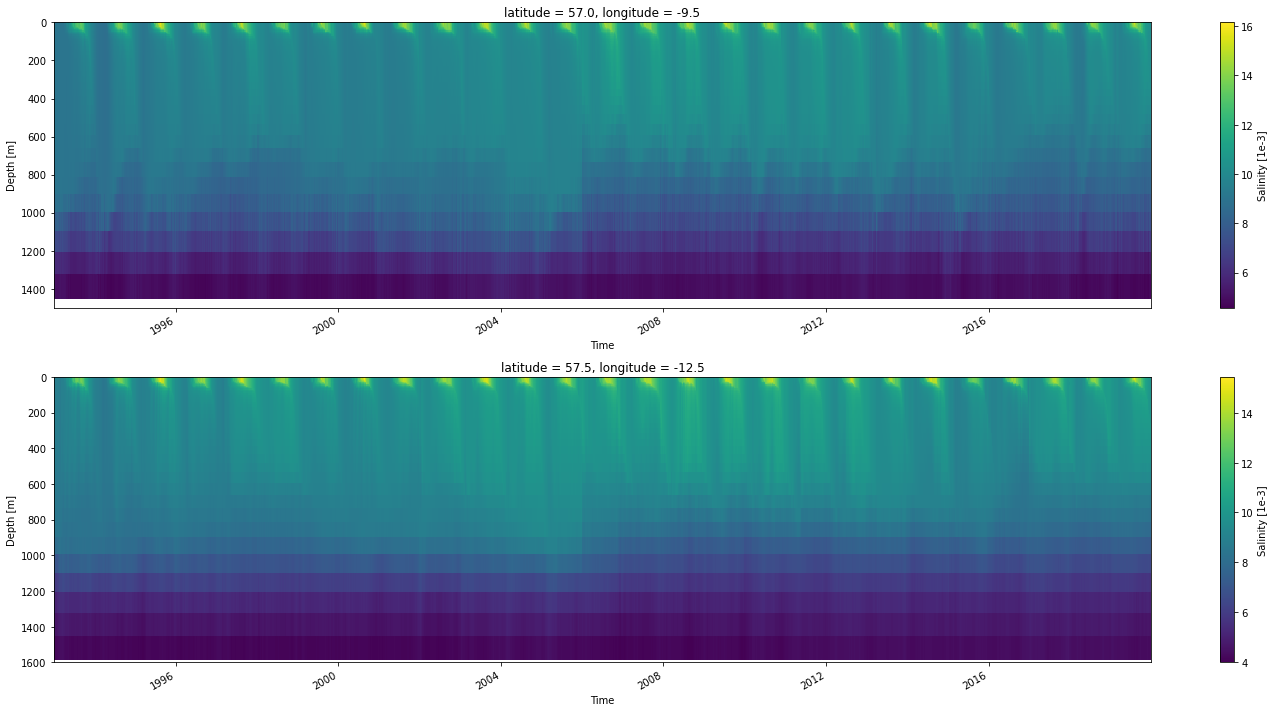

In [11]:
fig, ax = plt.subplots(2,1, figsize = (20, 10))
oras5_EB.plot(x='TIME', y='DEPTH', yincrease = False, ax = ax[0])
ax[0].set_ylim(1500,0)
oras5_WB.plot(x='TIME', y='DEPTH', yincrease = False,ax = ax[1])
ax[1].set_ylim(1600,0)
fig.tight_layout();

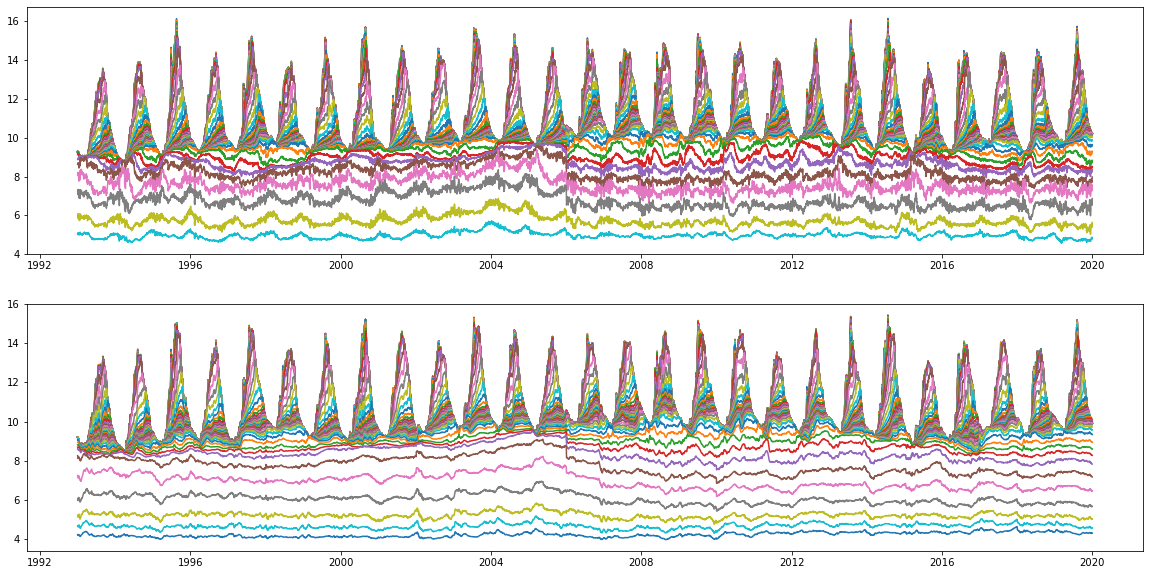

In [12]:
fig, ax = plt.subplots(2,1, figsize = (20,10))
ax[0].plot(oras5_EB.TIME, oras5_EB)
ax[1].plot(oras5_WB.TIME, oras5_WB);

# Functions

In [13]:
def MHW_func (data, depth, climP=[1993.0,2019.0], altClim=False):
    yy_start = int(data.TIME[0].dt.year)
    yy_end = int(data.TIME[-1].dt.year)
    mm_start = int(data.TIME[0].dt.month)
    mm_end = int(data.TIME[-1].dt.month)
    dd_start = int(data.TIME[0].dt.day)
    dd_end = int(data.TIME[-1].dt.day)
    
    t = np.arange(
        date(yy_start, mm_start, dd_start).toordinal(),                 
        date(yy_end, mm_end, dd_end).toordinal()+1,1) 
    
    temp = data.sel(DEPTH=depth, method = 'nearest').squeeze().values   
    
    mhws, clim = mhw.detect(t, temp, climatologyPeriod=climP, alternateClimatology=altClim)     
    mcss, clim_cold = mhw.detect(t, temp, coldSpells = True, climatologyPeriod=climP, alternateClimatology=altClim)     
    return mhws, mcss, clim, clim_cold, t, temp  

In [14]:
def DICT_func(data, depth, climP=[1993.0,2019.0], altClim=False):  
    mhws_,mcss_,clim_,clim_cold_,t_,temp_ = {},{},{},{},{},{}

    for n in depth:
            
        mhws, mcss, clim, clim_cold, t, temp = MHW_func(data, n, climP, altClim)
        mhws_.update({str(n):mhws})
        mcss_.update({str(n):mcss})
        clim_.update({str(n):clim})
        clim_cold_.update({str(n):clim_cold})
        t_.update({str(n):t})
        temp_.update({str(n):temp})
    
    dictionary = {'mhws':mhws_,'mcss':mcss_,'clim':clim_,'clim_cold':clim_cold_,'t':t_,'temp':temp_}
    return dictionary

In [15]:
def ALL_events(dict, n):
    
    #defining my variables
    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]

    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    plt.figure(figsize=(30,15))
    plt.subplot(2,1,1)
    
    plt.rc('font', size=20) #controls default text size
    plt.rc('axes', titlesize=25) #fontsize of the title
    plt.rc('legend', fontsize=14) #fontsize of the legend

    # Plot t, seasonal cycle, and threshold
    plt.plot(dates, clim['thresh'], ':r', label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', label = 'Threshold cold')
    plt.plot(dates, temp, 'k', label = 'Temperature', linewidth = .75)
    plt.plot(dates, clim['seas'], 'b', label = 'Climatology')
    plt.legend()
    plt.title(f'Data Overview {n}')
    plt.xlim(dates[0], dates[-1])
    #plt.xlim(date(2016,1,1), date(2017,5,1))
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.ylabel(r't $^\circ$C')
    plt.grid()
 
    # plt the heatwaves
    plt.subplot(2,1,2)

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]
        plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                         color='pink')

    # Find MHW of interest and shade accordingly
    ev_i = np.argmax(mhws['intensity_max'])
    t1 = np.where(t==mhws['time_start'][ev_i])[0][0]
    t2 = np.where(t==mhws['time_end'][ev_i])[0][0]
    plt.fill_between(dates[t1:t2+1], temp[t1:t2+1], clim['thresh'][t1:t2+1], \
                     color='deeppink', label = 'MHW event with max intensity')


    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                         color='cyan')

    # Find MCSS of interest and shade accordingly
    ec_i = np.argmin(mcss['intensity_max'])
    tc1 = np.where(t==mcss['time_start'][ec_i])[0][0]
    tc2 = np.where(t==mcss['time_end'][ec_i])[0][0]
    plt.fill_between(dates[tc1:tc2+1], temp[tc1:tc2+1], clim_cold['thresh'][tc1:tc2+1], \
                     color='darkcyan', label = 'MCSS event with max intensity')    

    # Plot t, seasonal cycle, threshold, shade MHWs with main event in red
    plt.plot(dates, clim['thresh'], ':r', linewidth=2, label = 'Threshold warm')
    plt.plot(dates, clim_cold['thresh'], ':g', linewidth=2, label = 'Threshold cold')
    plt.plot(dates, temp, 'k', linewidth=.75, label = 'Temperature')
    plt.plot(dates, clim['seas'], 'b', linewidth=2, label = 'Climatology')
    plt.legend()
    plt.title(f'Marine Heatwaves and Cold Spells {n}')
    #plt.xlim(date(2016,6,1), date(2018,6,1))
    #plt.xlim(dates[0], dates[-1])
    #plt.xlim(mhws['date_start'][ev-12], mhws['date_end'][ev+4])
    plt.ylim(temp.min()-0.1, temp.max()+0.1)
    plt.grid()
    plt.ylabel(r't $^\circ$C');

    
    #print some intersting stats
    print('Overview:')
    print('Number of MHWs: ', ev)
    print('Number of MCSs: ', ec)
    print('The MHWs of max intensity lastet from the', mhws['date_start'][ev_i], 'to the', mhws['date_end'][ev_i])
    print('The MCSs of max intensity lastet from the', mcss['date_start'][ec_i], 'to the', mcss['date_end'][ec_i])
    print(' ')

In [96]:
def OV_stacked_ax_events(dict, n, num, colour_mhw='deeppink', colour_mcs='darkcyan', mhw_l='MHWs', mcs_l='MCSs'):

    mhws = dict['mhws'][str(n)]
    mcss = dict['mcss'][str(n)]
    t = dict['t'][str(n)]
    temp = dict['temp'][str(n)]
    clim = dict['clim'][str(n)]
    clim_cold = dict['clim_cold'][str(n)]
    
    dates = [date.fromordinal(tt.astype(int)) for tt in t]
    
    ev = (mhws['n_events'])
    ec = (mcss['n_events'])

    # Find all MHWs and shade
    for ev0 in np.arange (ev):
        t1 = np.where(t==mhws['time_start'][ev0])[0][0]
        t2 = np.where(t==mhws['time_end'][ev0])[0][0]   
        ax[num].axvspan(xmin=dates[t1], xmax=dates[t2],color=colour_mhw, alpha=0.4, label = mhw_l)
            
    # same for cold spells
    for ec0 in np.arange(ec):
        tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
        tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
        ax[num].axvspan(xmin=dates[tc1], xmax=dates[tc2],color=colour_mcs, alpha=0.4, label = mcs_l)

    ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
    ax[num].grid(axis = 'x')
    ax[num].set_ylabel(str(n),rotation=0, labelpad=20)
    

       
    ax[num].tick_params(axis='y', which='both', right=False,
                left=False, labelleft=False);
    

In [86]:
def OV_stacked_events(dict, depth, w, h, title='bla', save=False):
    
    fig, ax = plt.subplots(len(depth),1, figsize=(w,h), sharex=True)
    fig.subplots_adjust(hspace=0)
    fig.tight_layout()
    
    for i,n in enumerate(depth):
        mhws = dict['mhws'][str(n)]
        mcss = dict['mcss'][str(n)]
        t = dict['t'][str(n)]
        temp = dict['temp'][str(n)]
        clim = dict['clim'][str(n)]
        clim_cold = dict['clim_cold'][str(n)]

        dates = [date.fromordinal(tt.astype(int)) for tt in t]

        ev = (mhws['n_events'])
        ec = (mcss['n_events'])

        # Find all MHWs and shade
        for ev0 in np.arange (ev):
            t1 = np.where(t==mhws['time_start'][ev0])[0][0]
            t2 = np.where(t==mhws['time_end'][ev0])[0][0]   
            ax[i].axvspan(xmin=dates[t1], xmax=dates[t2],color='deeppink', label= 'MHWs')
  
        # same for cold spells
        for ec0 in np.arange(ec):
            tc1 = np.where(t==mcss['time_start'][ec0])[0][0]
            tc2 = np.where(t==mcss['time_end'][ec0])[0][0]
            ax[i].axvspan(xmin=dates[tc1], xmax=dates[tc2],color='darkcyan', label = 'MCSs')
            
        #ax[num].set_xlim(date(2014,7,15), date(2020,10,20))
        ax[i].grid(axis = 'x')
        ax[i].set_ylabel(str(n),rotation=0, labelpad=20)
        ax[0].set_title(title)
        

        ax[i].tick_params(axis='y', which='both', right=False,
                    left=False, labelleft=False);
    if save:
        fig.savefig(f'figures/ORAS5/{title}', dpi = 300)
    

# Dictionary

In [17]:
# all depth
depth = np.array(oras5_EB.DEPTH).astype(int)
depth_short = np.array(oras5_EB.DEPTH.isel(DEPTH=slice(0,50))).astype(int)

In [18]:
# all years
ora_EB = DICT_func(oras5_EB, depth)
ora_WB = DICT_func(oras5_WB, depth)

In [19]:
# all years 2014-2019 year clim
ora_EB_clim = DICT_func(oras5_EB, depth, climP=[2014.0, 2019.0])
ora_WB_clim = DICT_func(oras5_WB, depth, climP=[2014.0, 2019.0])

In [26]:
# 2014-2019 years
ora_EB_6 = DICT_func(oras5_EB_6, depth, climP=[2014.0, 2019.0])
ora_WB_6 = DICT_func(oras5_WB_6, depth, climP=[2014.0, 2019.0])

In [38]:
# gridded data dictionary
EB = DICT_func(ds1D.TG_EAST_C, depth_EB, climP=[2014.0, 2020.0])
WB = DICT_func(ds1D.TG_WEST_C, depth_WB, climP=[2014.0, 2020.0])

In [45]:
ora_EB_6_EB = DICT_func(oras5_EB_6, depth_EB, climP=[2014.0, 2019.0])
ora_WB_6_EB = DICT_func(oras5_WB_6, depth_EB, climP=[2014.0, 2019.0])

# Plots EB

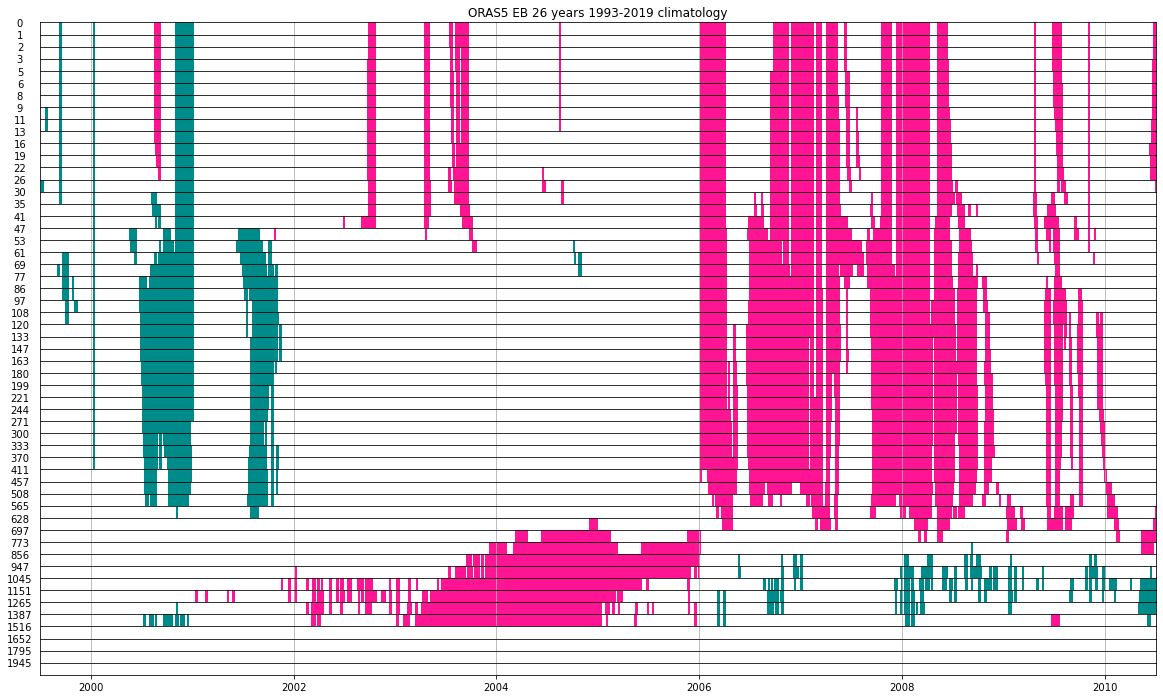

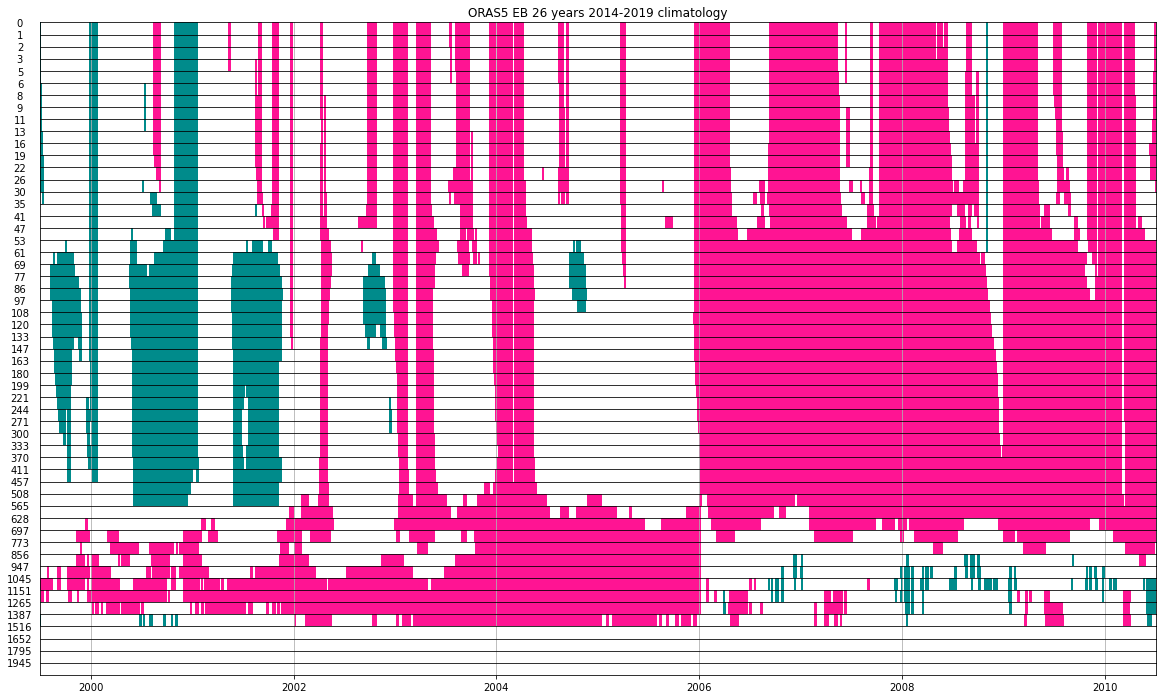

In [31]:
a = False
OV_stacked_events(ora_EB, depth, 20, 12, 'ORAS5 EB 26 years 1993-2019 climatology', save=a)
OV_stacked_events(ora_EB_clim, depth, 20, 12, 'ORAS5 EB 26 years 2014-2019 climatology', save=a)
OV_stacked_events(ora_EB_6, depth_short, 20, 12, 'ORAS5 EB 6 years 2014-2019 climatology', save=a)

# Plots WB

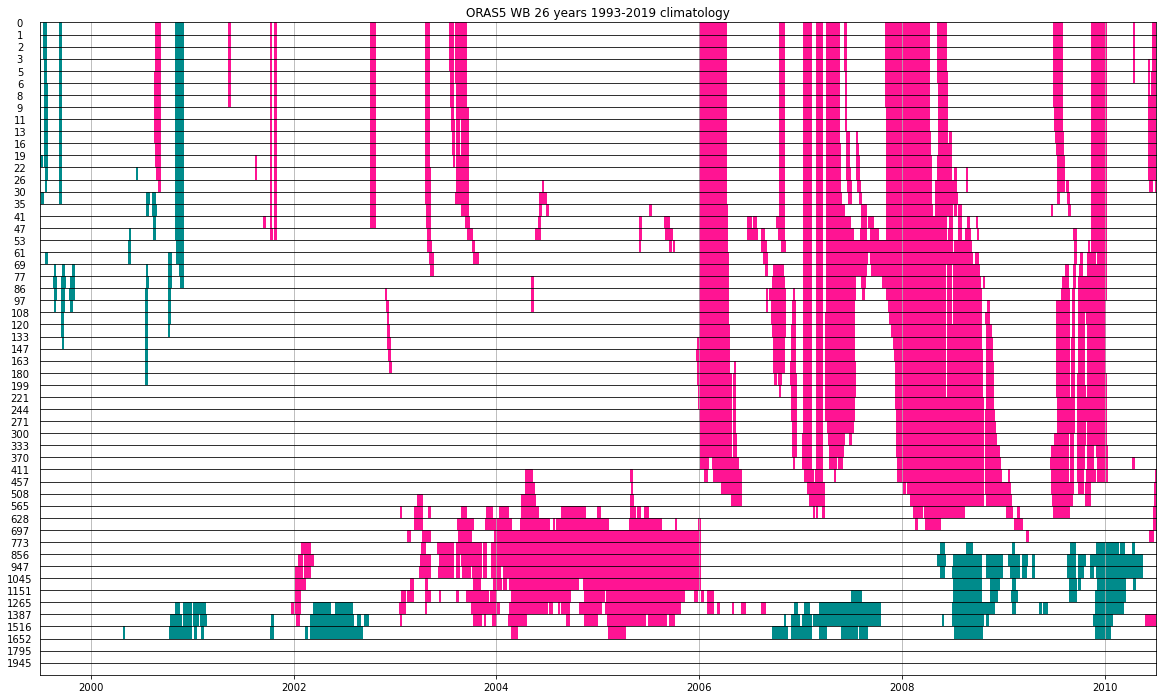

In [32]:
a = False
OV_stacked_events(ora_WB, depth, 20, 12, 'ORAS5 WB 26 years 1993-2019 climatology', save=a)   
OV_stacked_events(ora_WB_clim, depth, 20, 12, 'ORAS5 WB 26 years 2014-2019 climatology', save=a)
OV_stacked_events(ora_WB_6, depth_short, 20, 12, 'ORAS5 WB 6 years 2014-2019 climatology', save=a)

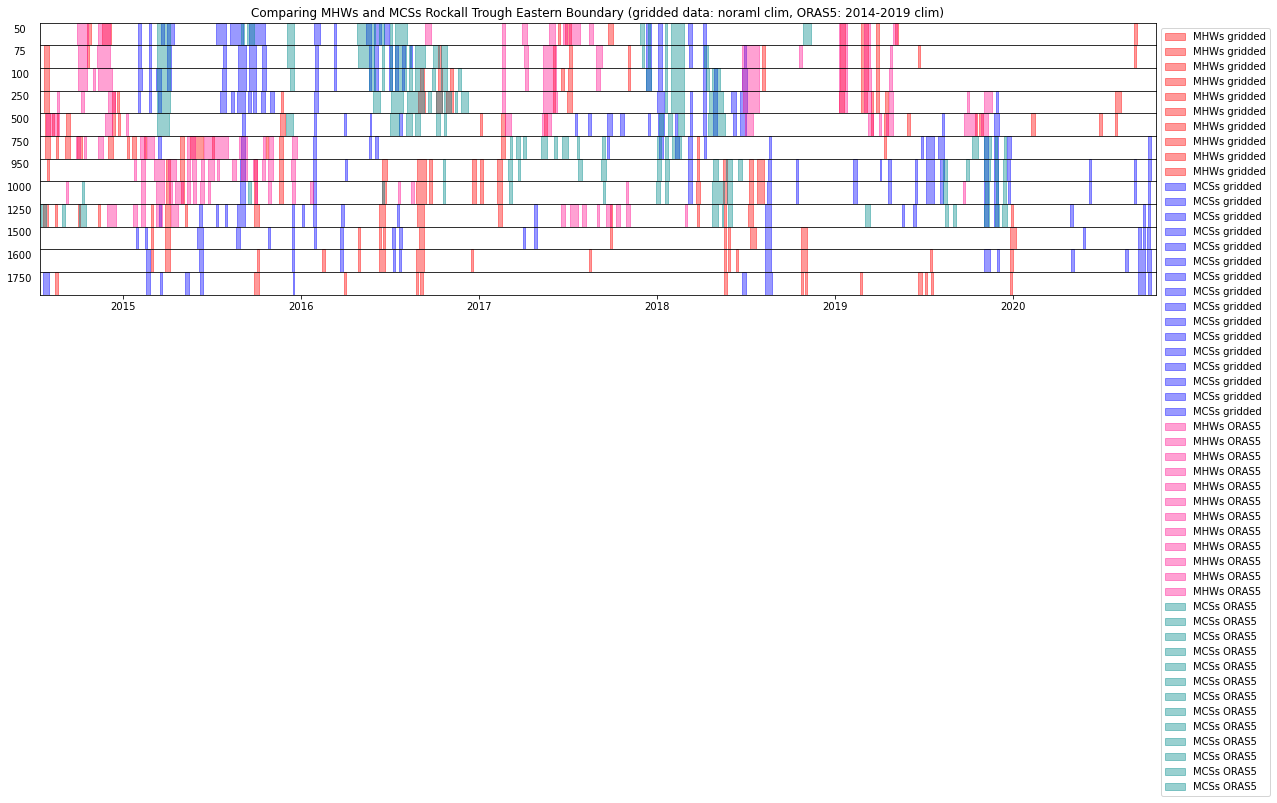

In [97]:
depth=depth_EB

title = 'Comparing MHWs and MCSs Rockall Trough Eastern Boundary (gridded data: noraml clim, ORAS5: 2014-2019 clim)'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(EB, n, i, colour_mhw='red', colour_mcs='blue', mhw_l='MHWs gridded', mcs_l='MCSs gridded');
    if n == 50:
        ax[i].set_title(title)
for i, n in enumerate(depth):        
    OV_stacked_ax_events(ora_EB_6_EB, n, i, mhw_l='MHWs ORAS5', mcs_l='MCSs ORAS5');

ax[0].legend(bbox_to_anchor=(1,1), loc="upper left");

#fig.savefig(f'figures/ORAS5_gridded_EB', dpi = 300, bbox_inches='tight')

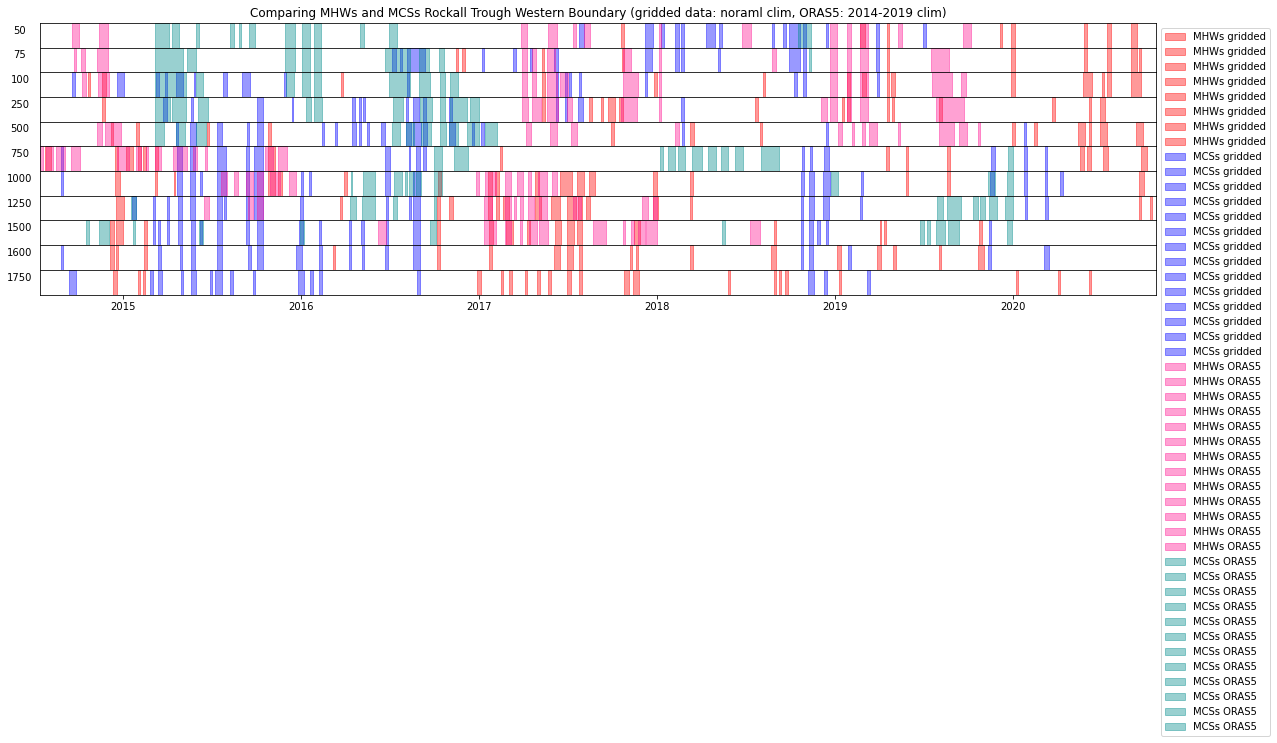

In [98]:
depth=depth_WB

title = 'Comparing MHWs and MCSs Rockall Trough Western Boundary (gridded data: noraml clim, ORAS5: 2014-2019 clim)'
fig, ax = plt.subplots((len(depth)),1, figsize = (20,5))
fig.subplots_adjust(hspace=0)
fig.tight_layout()
for i, n in enumerate(depth):
    OV_stacked_ax_events(WB, n, i, colour_mhw='red', colour_mcs='blue', mhw_l='MHWs gridded', mcs_l='MCSs gridded');
    if n == 50:
        ax[i].set_title(title)
for i, n in enumerate(depth):        
    OV_stacked_ax_events(ora_WB_6_EB, n, i, mhw_l='MHWs ORAS5', mcs_l='MCSs ORAS5');

ax[0].legend(bbox_to_anchor=(1,1), loc="upper left");

#fig.savefig(f'figures/ORAS5_gridded_WB', dpi = 300, bbox_inches='tight')